## This module provides an example of loading and plotting AMM7 data
### The exercise will introduce xarray and provide a first look at the AMM domain.


First we have the preamble.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import cartopy.feature as cfeature
import matplotlib
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# set default font size
matplotlib.rcParams.update({"font.size": 8})

#### Accessing the data
We now point to the dataset with xarray.
We use the phrase point rather than read/open because xarray uses lazy loading, which means data is only read when it is required. The chunks variable ensure the use of dask, the package that handles lazy loading.

In [2]:
# set paths
path = "/gws/nopw/j04/jmmp/tmp_slwa/AMM7_SSB_sample/"
fn = "amm7_1d_20040101_20040131_grid_T.nc"

# get data
ds = xr.open_dataset(path + fn, chunks=-1)

#### Subsetting the data
There are two main routes for subsetting the data with Xarray, by index label (.sel) and by index (.isel). The data daily output for January 2004 and we can view its contents without any loading.

In [3]:
ds

<xarray.Dataset>
Dimensions:               (deptht: 51, axis_nbounds: 2, time_counter: 31,
                           y: 375, x: 297)
Coordinates:
  * deptht                (deptht) float32 3.038 9.367 ... 5.618e+03 5.822e+03
    nav_lat               (y, x) float32 dask.array<chunksize=(375, 297), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(375, 297), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2004-01-01T12:00:00 ....
Dimensions without coordinates: axis_nbounds, y, x
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(51, 2), meta=np.ndarray>
    e3t                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(31, 51, 375, 297), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    vosaline              (time_counter, deptht, y, x) float32 dask.array<chunksize=(31, 51, 375, 297), meta=np.ndarray>
    votemper              (time_counter, deptht, y, x) float32 dask.array<chunksize=(31, 51, 375, 297), meta=np.ndarray>
Attributes:
    name:         amm7_1d_20040101_20040131
    description:  tracer variables
    title:        tracer variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2016-Dec-30 12:05:10 GMT
    history:      Thu Jan 18 08:10:23 2024: ncks -v votemper,vosaline,e3t /gw...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...

We select the time by simply selecting the desired data.

In [4]:
# subsetting by index label
ds_t0 = ds.sel(time_counter="2004-01-01")

This opperation leaves length 1 time_counter dimension, and we'll now remove this.

In [5]:
# remove dims length 1
ds_t0 = ds_t0.squeeze()

We can also subset by index.

In [6]:
# subsetting data - by index
ds_t0_surf = ds_t0.isel(deptht=0)

This leave us with dimension of x and y for the surface and we are ready to view the fields. Xarray has its own built in quick plot functions and we'll demonstrate this by plotting temperature.

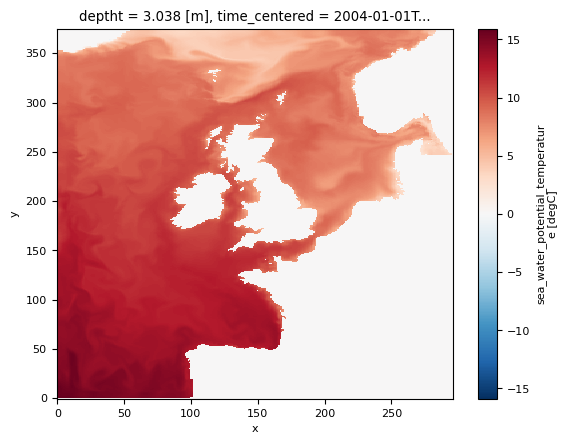

In [7]:
ds_t0_surf.votemper.plot()

### Plotting
The following plotting is included for those who wish to see more taylored plotting techniques with matplotlib. However, we assume general familarity with matplotlib and we add this for reference.

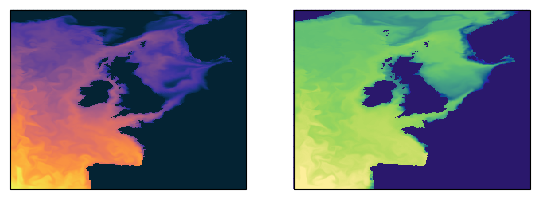

In [8]:
# set axes
plt_proj = ccrs.PlateCarree()
proj_dict = {"projection": plt_proj}
fig, axs = plt.subplots(1, 2, figsize=(6.5,3.0), subplot_kw=proj_dict)
plt.subplots_adjust(left=0.10, right=0.90, top=0.95, bottom=0.22)
    
# set colour bar limits
tmin, tmax = 6, 16
smin, smax = 33.5, 36

# render temperature
pt = axs[0].pcolor(ds_t0_surf.nav_lon, ds_t0_surf.nav_lat, ds_t0_surf.votemper, 
                   vmin=tmin, vmax=tmax, transform=plt_proj, 
                   cmap=cmocean.cm.thermal, shading="nearest")

# render salinity
ps = axs[1].pcolor(ds_t0_surf.nav_lon, ds_t0_surf.nav_lat, ds_t0_surf.vosaline, 
                   vmin=smin, vmax=smax, transform=plt_proj, 
                   cmap=cmocean.cm.haline, shading="nearest")


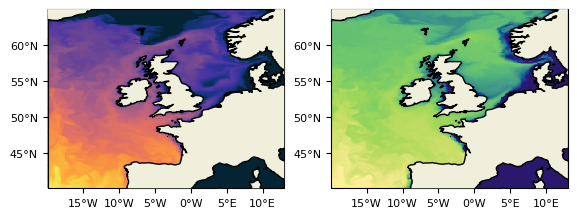

In [9]:
# format axes
for ax in axs:
    # set domain bounds
    ax.set_xlim(ds_t0.nav_lon.min().values,ds_t0.nav_lon.max().values)
    ax.set_ylim(ds_t0.nav_lat.min().values,ds_t0.nav_lat.max().values)
        
    # add land
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')

    # set axis ticks 
    ax.set_xticks([-15, -10, -5, 0, 5, 10], crs=ccrs.PlateCarree())
    ax.set_yticks([45, 50, 55, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

fig

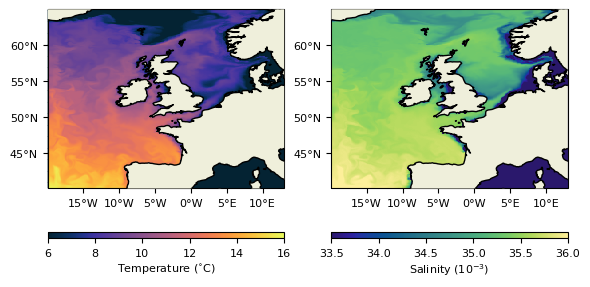

In [10]:
def add_cbar(fig, ax, p, txt):
    """
    Add horizontal colour bar beneath axis.
    """

    pos = ax.get_position()
    cbar_ax = fig.add_axes([pos.x0, 0.12, pos.x1 - pos.x0, 0.02])
    cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
    cbar.ax.text(0.5, -3.8, txt, transform=cbar.ax.transAxes,
                 va='top', ha='center')
    
# set color bars 
add_cbar(fig, axs[0], pt, r"Temperature ($^{\circ}$C)")
add_cbar(fig, axs[1], ps, r"Salinity (10$^{-3})$")

fig

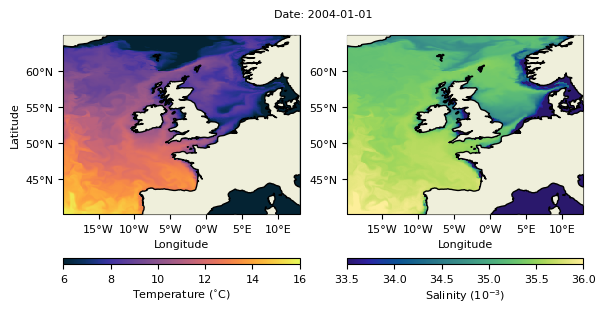

In [11]:
# add date title
date_str = "Date: " + ds_t0.time_counter.dt.strftime("%Y-%m-%d").values
axs[0].text(0.5, 0.97, date_str, transform=fig.transFigure, 
                ha="center", va="top")

# add axes labels
for ax in axs:
    ax.set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
    
fig